In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import MinMaxScaler

from keras.models import Model,Sequential, load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint

from keras.layers import LSTM,Dense,Dropout,Activation, GRU
from keras.optimizers import Adam, RMSprop, Nadam
plt.style.use('bmh')

In [3]:
%cd /content/drive/My Drive/optimum/timeseries

/content/drive/My Drive/optimum/timeseries


In [4]:
df = pd.read_csv('ETHUSDT-1h-data-original.csv')

In [399]:
df.corr()

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,ma9,ma26,change_price,ohlc/4,updown
open,1.000000,0.999933,0.999836,0.999841,0.297661,0.753607,0.750638,0.296932,0.757735,0.999755,0.998971,-0.000658,0.999953,0.018833
high,0.999933,1.000000,0.999786,0.999909,0.300919,0.757173,0.754109,0.300496,0.761619,0.999759,0.999046,0.006912,0.999958,0.021675
low,0.999836,0.999786,1.000000,0.999883,0.290976,0.745366,0.743139,0.290862,0.750189,0.999523,0.998582,0.010884,0.999926,0.022269
close,0.999841,0.999909,0.999883,1.000000,0.296717,0.752198,0.749491,0.296671,0.757087,0.999655,0.998840,0.017177,0.999959,0.024794
volume,0.297661,0.300919,0.290976,0.296717,1.000000,0.632055,0.715524,0.993235,0.629090,0.300238,0.303696,-0.050487,0.296611,-0.002288
quote_av,0.753607,0.757173,0.745366,0.752198,0.632055,1.000000,0.965420,0.626356,0.996857,0.757218,0.762068,-0.072759,0.752158,0.006809
trades,0.750638,0.754109,0.743139,0.749491,0.715524,0.965420,1.000000,0.709650,0.963472,0.753800,0.757623,-0.058088,0.749413,0.007217
tb_base_av,0.296932,0.300496,0.290862,0.296671,0.993235,0.626356,0.709650,1.000000,0.629437,0.299281,0.302487,-0.012167,0.296283,0.031444
tb_quote_av,0.757735,0.761619,0.750189,0.757087,0.629090,0.996857,0.963472,0.629437,1.000000,0.761072,0.765663,-0.030026,0.756728,0.021639
ma9,0.999755,0.999759,0.999523,0.999655,0.300238,0.757218,0.753800,0.299281,0.761072,1.000000,0.999480,0.002618,0.999725,0.020274


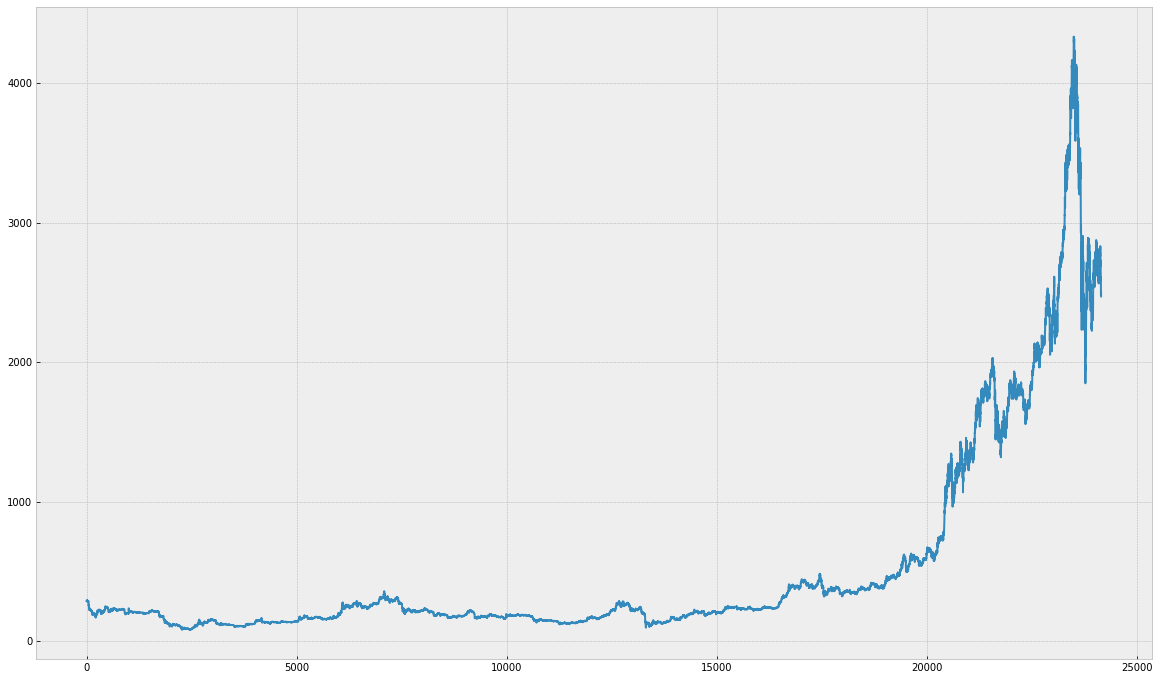

In [23]:
#데이터 시각화를 위한 변수 지정
series = df['close'].values.reshape(-1, 1)

#전체 데이터 확인 / x: index , y= close 종가
plt.figure(figsize=(20,12))
plt.plot(series)
plt.show()

In [26]:
data = df[['close', 'volume', 'trades']]

In [27]:
for c in data.columns :
  data[f'{c}_1'] = data[c].shift(-1)
data.dropna(inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
data.corr()

,close,volume,trades,close_1,volume_1,trades_1
close,1.000000,0.296679,0.749478,0.999841,0.297662,0.750649
volume,0.296679,1.000000,0.715517,0.296949,0.724268,0.575723
trades,0.749478,0.715517,1.000000,0.749728,0.572739,0.866118
close_1,0.999841,0.296949,0.749728,1.000000,0.296712,0.749490
volume_1,0.297662,0.724268,0.572739,0.296712,1.000000,0.715521
trades_1,0.750649,0.575723,0.866118,0.749490,0.715521,1.000000


In [31]:
model = Sequential()
model.add(LSTM(64, input_shape=(5, 1),activation = 'swish'))# (Low) relu <<< swish (Best)
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse', metrics = ['mae']) # (Low) rmsprop < adam < nadam (Best)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [40]:
#val_loss가 50회 이상 증가할 때 학습을 조기 종료 시킴
es = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience = 15)
mc = ModelCheckpoint('best_model.h5', monitor='val_mae', mode='min', save_best_only=True, verbose = 1)

In [33]:
### 기존 코드의 scl = MinMaxScaler()를 스케일러를 두개 사용해야하므로 변수이름으로 2개를 나눈 것 입니다.
scl_x = MinMaxScaler() # 외생변수 스케일링을 위한 스케일러
scl_y = MinMaxScaler() # 종속변수 스케일링을 위한 스케일러

스케일러를 두개로 나눈 이유는 값을 inverse_transform 할 때 예를 들어 5개 column에 대해 스케일링을 학습한 스케일러로 1개 column을 복원(inverse transform)할 수 없습니다. n개 column에 대한 스케일러는 똑같은 column에 대해 복원을 합니다.

In [34]:
scaled_x = scl_x.fit_transform(data.drop('close_1', axis = 1))

In [35]:
X_train = scaled_x[:int(scaled_x.shape[0] * .9)]
X_test = scaled_x[int(scaled_x.shape[0] * .9) : ]

train을 전체의 90% test를 전체의 10%로 지정합니다.

In [36]:
tr_input = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # X_train과 동일, 변수 이름만 tr_input일 뿐
te_input = X_test.reshape(X_test.shape[0], X_test.shape[1], 1) # X_test와 동일 변수, 이름만 tr_input일 뿐

나누어진 train & test data를 모델에 넣기 위해 형태를 재조정(reshape)해줍니다.

In [38]:
scaled_y = scl_y.fit_transform(data.close_1.values.reshape(-1, 1))

우선 종속변수를 스케일링 해줍니다.

In [39]:
tr_y_scaled = scaled_y[ : X_train.shape[0]] # y_train 형태와 동일, 변수 이름만 tr_y_scaled일 뿐
te_y_scaled = scaled_y[X_train.shape[0] : ] # y_test 형태와 동일, 변수 이름만 te_y_scaled일 뿐

종속변수도 각 train & test 크기 만큼 분할해줍니다.

In [41]:
#모델 학습
history = model.fit(tr_input, tr_y_scaled,epochs=123456,validation_data = (te_input, te_y_scaled), shuffle=True, batch_size = 32,
                    callbacks=[es,mc])
#shuffle은 False가 아닌 True로 설정 시 rmse정확도 향상됨. 원인은 모름, 공부해야됨.

Epoch 1/123456
680/680 [==============================] - 6s 6ms/step - loss: 0.0037 - mae: 0.0333 - val_loss: 0.0121 - val_mae: 0.0755

Epoch 00001: val_mae improved from inf to 0.07550, saving model to best_model.h5
Epoch 2/123456
680/680 [==============================] - 3s 5ms/step - loss: 2.9780e-04 - mae: 0.0107 - val_loss: 0.0225 - val_mae: 0.0871

Epoch 00002: val_mae did not improve from 0.07550
Epoch 3/123456
680/680 [==============================] - 3s 5ms/step - loss: 1.8730e-04 - mae: 0.0089 - val_loss: 0.0268 - val_mae: 0.1222

Epoch 00003: val_mae did not improve from 0.07550
Epoch 4/123456
680/680 [==============================] - 3s 5ms/step - loss: 1.1518e-04 - mae: 0.0069 - val_loss: 0.0027 - val_mae: 0.0271

Epoch 00004: val_mae improved from 0.07550 to 0.02709, saving model to best_model.h5
Epoch 5/123456
680/680 [==============================] - 3s 5ms/step - loss: 7.4814e-05 - mae: 0.0057 - val_loss: 0.0137 - val_mae: 0.0635

Epoch 00005: val_mae did not impr

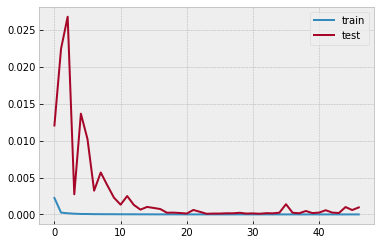

In [42]:
#loss시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
model = load_model('best_model.h5')

Text(0.5, 1.0, 'Train')

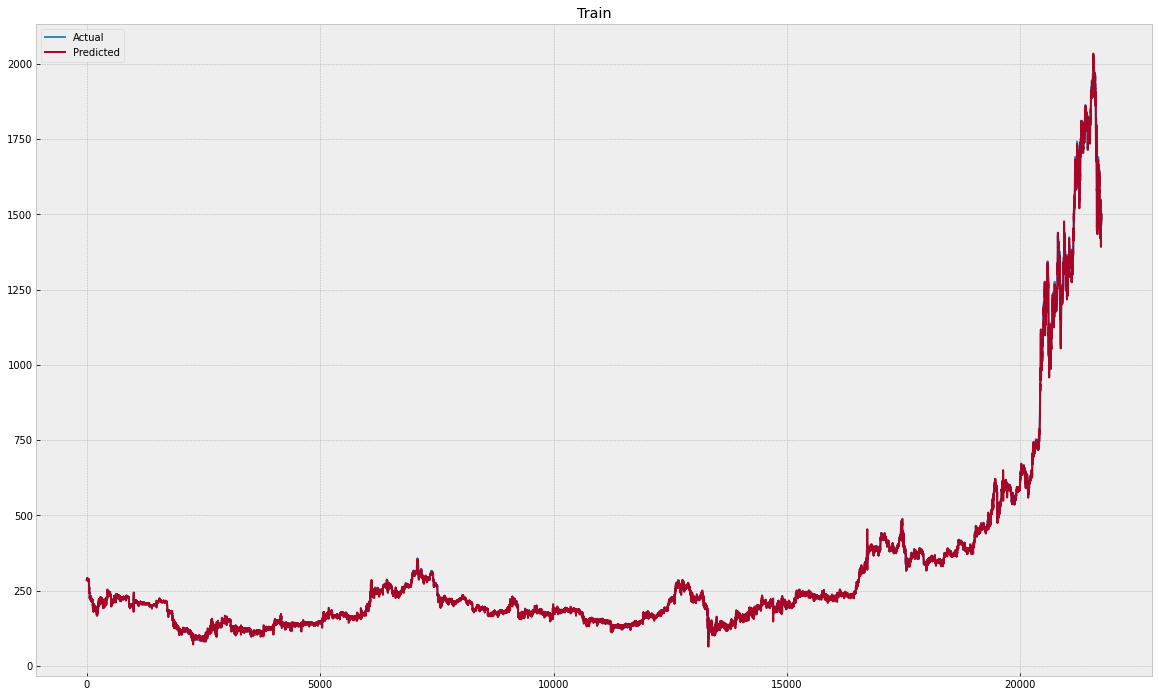

In [44]:
#공부시킨 결과 확인
plt.figure(figsize=(20,12))
Xt = model.predict(tr_input)
plt.plot(scl_y.inverse_transform(tr_y_scaled), label="Actual")
plt.plot(scl_y.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train")
#잘못 학습된 경우, Actual을 Predicted가 따라가는 형태로 되므로 확대해서 확인해야함.

Text(0.5, 1.0, 'Test Dataset')

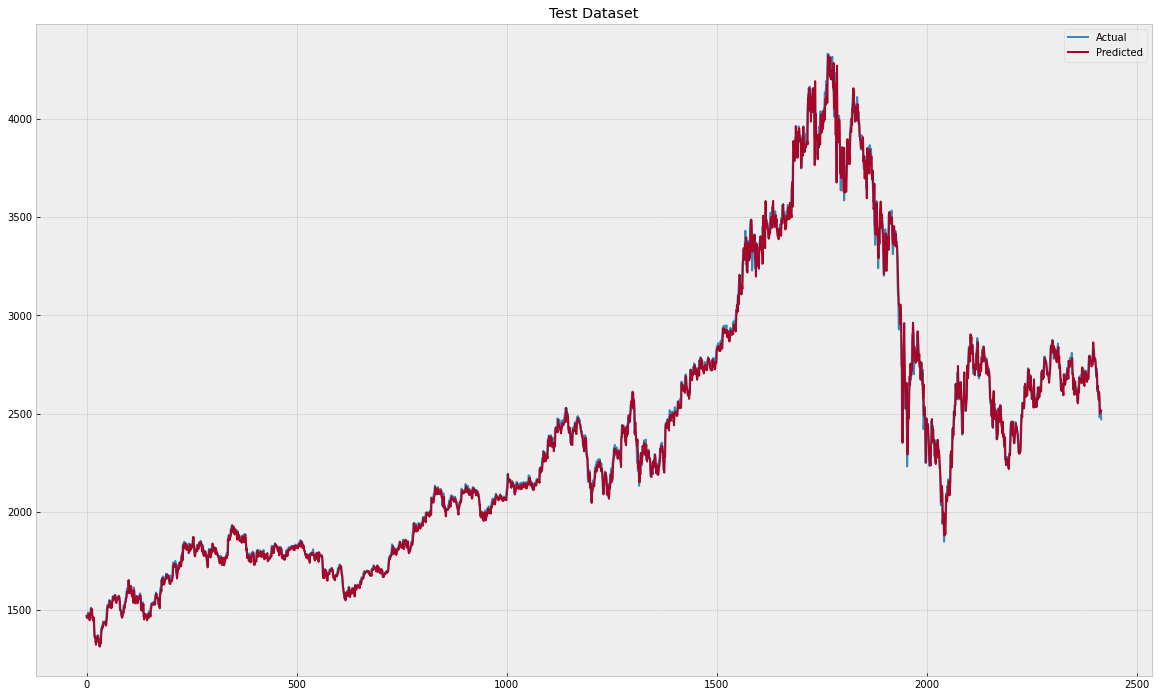

In [45]:
#모델 성능 확인
plt.figure(figsize=(20,12))
Xt = model.predict(te_input)
Predict = scl_y.inverse_transform(Xt)
Actual = scl_y.inverse_transform(te_y_scaled.reshape(-1, 1))
plt.plot(Actual, label="Actual")
plt.plot(Predict, label="Predicted")
plt.legend()
plt.title("Test Dataset")
#잘못 학습된 경우, Actual을 Predicted가 따라가는 형태로 되므로 확대해서 확인해야함.

In [46]:
from sklearn.metrics import mean_squared_error
print(f'LSTM의 RMSE는 {np.sqrt(mean_squared_error(Actual, Predict))}')
#(rmse는 0에 가까울수록 좋음)

LSTM의 RMSE는 41.87935461324177


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('ETHUSDT-1h-data-original.csv')

In [3]:
df.corr()

,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,ma9,ma26,change_price,ohlc/4,updown
open,1.000000,0.999933,0.999836,0.999841,0.297661,0.753607,0.750638,0.296932,0.757735,0.999755,0.998971,-0.000658,0.999953,0.018833
high,0.999933,1.000000,0.999786,0.999909,0.300919,0.757173,0.754109,0.300496,0.761619,0.999759,0.999046,0.006912,0.999958,0.021675
low,0.999836,0.999786,1.000000,0.999883,0.290976,0.745366,0.743139,0.290862,0.750189,0.999523,0.998582,0.010884,0.999926,0.022269
close,0.999841,0.999909,0.999883,1.000000,0.296717,0.752198,0.749491,0.296671,0.757087,0.999655,0.998840,0.017177,0.999959,0.024794
volume,0.297661,0.300919,0.290976,0.296717,1.000000,0.632055,0.715524,0.993235,0.629090,0.300238,0.303696,-0.050487,0.296611,-0.002288
quote_av,0.753607,0.757173,0.745366,0.752198,0.632055,1.000000,0.965420,0.626356,0.996857,0.757218,0.762068,-0.072759,0.752158,0.006809
trades,0.750638,0.754109,0.743139,0.749491,0.715524,0.965420,1.000000,0.709650,0.963472,0.753800,0.757623,-0.058088,0.749413,0.007217
tb_base_av,0.296932,0.300496,0.290862,0.296671,0.993235,0.626356,0.709650,1.000000,0.629437,0.299281,0.302487,-0.012167,0.296283,0.031444
tb_quote_av,0.757735,0.761619,0.750189,0.757087,0.629090,0.996857,0.963472,0.629437,1.000000,0.761072,0.765663,-0.030026,0.756728,0.021639
ma9,0.999755,0.999759,0.999523,0.999655,0.300238,0.757218,0.753800,0.299281,0.761072,1.000000,0.999480,0.002618,0.999725,0.020274


In [4]:
df.drop(['high', 'low', 'ma9', 'ohlc/4'], axis = 1, inplace = True)

In [5]:
df['shift_10'] = df.close.shift(-10)

In [6]:
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

In [64]:
lgbm = LGBMRegressor(random_state = 620, max_depth = 4, n_estimators = 1000)

In [65]:
X_train = df.iloc[:24000,1:-1]
X_test = df.iloc[24000:-10, 1:-1]
y_train = df.shift_10.iloc[:24000]
y_test = df.close.iloc[24010:]

In [66]:
lgbm.fit(X_train, y_train)

LGBMRegressor(max_depth=4, n_estimators=1000, random_state=620)

In [67]:
pred = lgbm.predict(X_test).tolist()

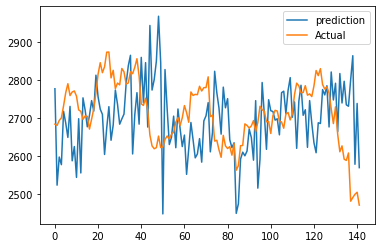

In [68]:
plt.plot(pred, label = 'prediction')
plt.plot(y_test.tolist(), label = 'Actual')
plt.legend()
plt.show()

In [69]:
import numpy as np

In [70]:
rmse = np.sqrt(mean_squared_error(y_test ,pred))

In [71]:
rmse

121.59859171991812